In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

# PTML Project: NASA Nearest Object from Earth

Authors:
* Baptiste Bourdet
* Philippe Bernet
* Marius Dubosc
* Hugo Levy

The dataset comes from Kaggle: https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects.

In this report we will try to analyze this data and compute models of both supervised and unsupervised learning to respond to a problem that was highlighted in many movies of science fiction: are any objects currently in orbit a danger to either satellites or earth.

## Loading the data

First we need to load the data and analyse the different component it is made out of.

In [2]:
df = pd.read_csv("neo.csv")
# set the id column to be a category
df["id"] = df["id"].astype(object)
df["orbiting_body"] = df["orbiting_body"].astype('category')
df

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
...,...,...,...,...,...,...,...,...,...,...
90831,3763337,(2016 VX1),0.026580,0.059435,52078.886692,1.230039e+07,Earth,False,25.00,False
90832,3837603,(2019 AD3),0.016771,0.037501,46114.605073,5.432121e+07,Earth,False,26.00,False
90833,54017201,(2020 JP3),0.031956,0.071456,7566.807732,2.840077e+07,Earth,False,24.60,False
90834,54115824,(2021 CN5),0.007321,0.016370,69199.154484,6.869206e+07,Earth,False,27.80,False


The data is composed of the following columns:
* id: index number
* name: name of the object
* est_dimater_min: smallest size of the object in km
* est_dimater_max: biggest size of the object in km
* relative_velocity: velocity relative to Earth in km/h
* orbiting_body: the body the object is orbiting (Earth, Sun, the Moon ...)
* sentry_object: whether or not the object is tracked by the sentry system of the nasa
* absolute_magnitude: visibility index, the smaller it is, the brigther the object it, the magnitude of the sun is -27 for example
* **hazardous**: whether or not the object is considerer a potential threat by the nasa, it is this column we will want to monitor

# Analysis

First we will look at statistics on the dataset.

In [3]:
print(f"Length of the dataset is {len(df)}")

Length of the dataset is 90836


In [4]:
print("Summary of all numerical values :")
print(df.describe())

Summary of all numerical values :
       est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
count      90836.000000      90836.000000       90836.000000   9.083600e+04   
mean           0.127432          0.284947       48066.918918   3.706655e+07   
std            0.298511          0.667491       25293.296961   2.235204e+07   
min            0.000609          0.001362         203.346433   6.745533e+03   
25%            0.019256          0.043057       28619.020645   1.721082e+07   
50%            0.048368          0.108153       44190.117890   3.784658e+07   
75%            0.143402          0.320656       62923.604633   5.654900e+07   
max           37.892650         84.730541      236990.128088   7.479865e+07   

       absolute_magnitude  
count        90836.000000  
mean            23.527103  
std              2.894086  
min              9.230000  
25%             21.340000  
50%             23.700000  
75%             25.700000  
max             33.200000  


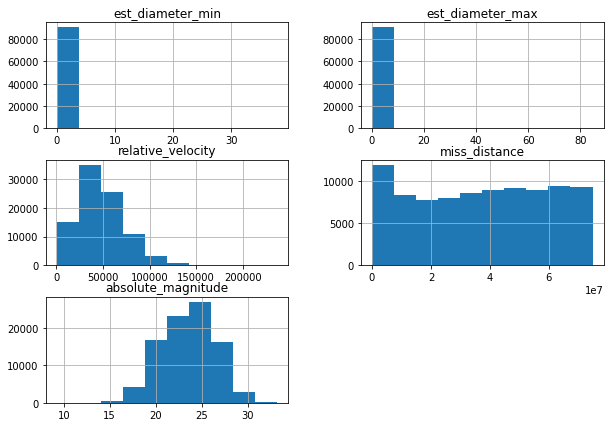

In [5]:
df.hist(bins=10, figsize=(10, 7))
pass

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  90836 non-null  object  
 1   name                90836 non-null  object  
 2   est_diameter_min    90836 non-null  float64 
 3   est_diameter_max    90836 non-null  float64 
 4   relative_velocity   90836 non-null  float64 
 5   miss_distance       90836 non-null  float64 
 6   orbiting_body       90836 non-null  category
 7   sentry_object       90836 non-null  bool    
 8   absolute_magnitude  90836 non-null  float64 
 9   hazardous           90836 non-null  bool    
dtypes: bool(2), category(1), float64(5), object(2)
memory usage: 5.1+ MB


In [7]:
print("Visualization of categorical values :")
print(df.describe(include=['category', 'bool']))

Visualization of categorical values :
       orbiting_body sentry_object hazardous
count          90836         90836     90836
unique             1             1         2
top            Earth         False     False
freq           90836         90836     81996


As we can see we have

In [8]:
def show3D_data(df, x, y, z, only_anomalies=False):
    X = df.drop(columns=["label"])
    Y = df["label"] != "background"

    zOffset = 0.02
    limit = len(X)

    sb.reset_orig()

    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot(111, projection="3d")

    if not only_anomalies:
        ax.scatter(
            X.loc[Y == False, x][:limit],
            X.loc[Y == False, y][:limit],
            -np.log10(X.loc[Y == False, z][:limit] + zOffset),
            c="g",
            marker=".",
            s=10,
            label="background",
        )

    ax.scatter(
        X.loc[Y == True, x][:limit],
        X.loc[Y == True, y][:limit],
        -np.log10(X.loc[Y == True, z][:limit] + zOffset),
        c="r",
        marker=".",
        s=10,
        label="anomaly",
    )

    ax.set_xlabel(x, size=16)
    ax.set_ylabel(y + " [hour]", size=16)
    ax.set_zlabel("- log$_{10}$ (" + z + ")", size=16)
    if not only_anomalies:
        ax.set_title(
            "Error-based features separate out normal and anomalies transfer", size=20
        )
    else:
        ax.set_title("Error-based features only for anomalies transfer", size=20)

    plt.axis("tight")
    ax.grid(1)

    normalMarker = (
        mlines.Line2D(
            [],
            [],
            linewidth=0,
            color="g",
            marker=".",
            markersize=10,
            label="background",
        )
        if not only_anomalies
        else None
    )

    anomalyMarker = mlines.Line2D(
        [], [], linewidth=0, color="r", marker=".", markersize=10, label="anomaly"
    )

    plt.legend(
        handles=[anomalyMarker] if only_anomalies else [normalMarker, anomalyMarker],
        bbox_to_anchor=(1.20, 0.38),
        frameon=False,
        prop={"size": 16},
    )

## Supervised Learning

First, we clean the dataset to get quantitative data to determine wether or not the object is considerer a potential threat by the nasa, it is this column we will want to monitor. We remove constant values (sentry_object=False and orbiting_body=Earth)

In [9]:
df_ml = df.drop(["name", "orbiting_body", "sentry_object"], axis=1)
df_ml = df_ml.set_index("id")
df_ml

/home/pippo/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
id,,,,,,
2162635,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
2277475,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2512244,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3596030,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
3667127,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True
...,...,...,...,...,...,...
3763337,0.026580,0.059435,52078.886692,1.230039e+07,25.00,False
3837603,0.016771,0.037501,46114.605073,5.432121e+07,26.00,False
54017201,0.031956,0.071456,7566.807732,2.840077e+07,24.60,False


## Initialize train and test sets

In [10]:
from sklearn.model_selection import train_test_split

X = df[["est_diameter_min","est_diameter_max","relative_velocity","miss_distance","absolute_magnitude"]]
y = df["hazardous"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Let's try multiple models

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, r2_score

def try_model(model):
    print(model)
    model.fit(X_train, y_train)

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    def print_metric(metric):
        print(metric)
        print(f"train : {metric(y_train,y_train_predict)}")
        print(f"test : {metric(y_test,y_test_predict)}")
    
    metrics = [
        classification_report,
        accuracy_score
    ]

    for metric in metrics:
        print_metric(metric)

    print(f"Confusion matrix on test :\n{confusion_matrix(y_test, y_test_predict, normalize='true')}\n")
    
models = [
    LogisticRegressionCV(class_weight="balanced"),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(max_depth=3, random_state=0, n_estimators = 50),
]

for model in models:
    try_model(model)

LogisticRegressionCV(class_weight='balanced')
<function classification_report at 0x7ff61c28b880>
train :               precision    recall  f1-score   support

       False       0.94      0.38      0.54     54969
        True       0.12      0.76      0.20      5891

    accuracy                           0.41     60860
   macro avg       0.53      0.57      0.37     60860
weighted avg       0.86      0.41      0.50     60860

test :               precision    recall  f1-score   support

       False       0.93      0.38      0.54     27027
        True       0.12      0.76      0.20      2949

    accuracy                           0.42     29976
   macro avg       0.53      0.57      0.37     29976
weighted avg       0.85      0.42      0.51     29976

<function accuracy_score at 0x7ff61c28af80>
train : 0.41390075583305946
test : 0.4150987456631972
Confusion matrix on test :
[[0.37758538 0.62241462]
 [0.24109868 0.75890132]]

KNeighborsClassifier()
<function classification_report at